In [1]:
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import scipy.interpolate
import os
import shutil
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import unfolding_network
import data_generation
import constants

import sys
sys.path.append(constants.HOME_DIR)
sys.path.append('/FRUIT')

import scienceplots
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('science')
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=3.0)

plt.style.reload_library()


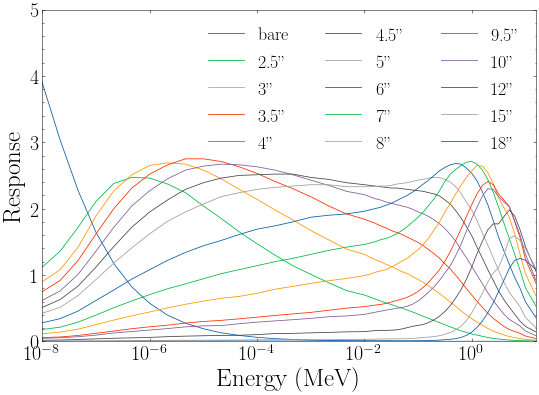

In [2]:
fig, ax = plt.subplots(1,1, figsize = (8,6))

thicknesses = ["bare", "2.5\"", "3\"", "3.5\"", "4\"", "4.5\"", "5\"", "6\"", "7\"", "8\"", "9.5\"", "10\"", "12\"", "15\"", "18\""]

i = 0
for row in constants.cm:
    ax.plot(constants.Ebins * 1e-6, row, linewidth = 0.8, label = thicknesses[i])
    i += 1
    
ax.set_xscale("log")
ax.set_ylabel("Response", fontsize = 25, fontweight = "bold")
ax.set_xlabel("Energy (MeV)", fontsize = 25, fontweight = "bold")
ax.legend(ncol = 3, fontsize = 18)

ax.set_xlim(1e-8, 16)
ax.set_ylim(0, 5)
plt.tight_layout()
plt.savefig("IAEA_Bonner_Response", dpi = 300)



In [3]:
# ~~ Shuffles the IAEA data into one set to perturb ~~ # 
# ~~ from and one to evaluate performance against   ~~ #

xeval, yeval = None, None
xother, yother = None, None

def shuffle_test_data():
    global xeval, yeval, xother, yother
    x,y = data_generation.x_data_IAEA, data_generation.y_data_IAEA
    boot = ShuffleSplit(n_splits = 1, test_size = 0.75)
    for other, test in boot.split(x):
        xeval, yeval = x[test], y[test]
        xother, yother = x[other], y[other]
        return

def save_shuffle():
    np.save("./NeutronSpectraGeneration/saved_networks/xeval", xeval)
    np.save("./NeutronSpectraGeneration/saved_networks/yeval", yeval)
    np.save("./NeutronSpectraGeneration/saved_networks/xother", xother)
    np.save("./NeutronSpectraGeneration/saved_networks/yother", yother)
    
def load_shuffle():
    global xeval, yeval, xother, yother
    xeval = np.load("./NeutronSpectraGeneration/saved_networks/xeval.npy")
    yeval = np.load("./NeutronSpectraGeneration/saved_networks/yeval.npy")
    xother = np.load("./NeutronSpectraGeneration/saved_networks/xother.npy")
    yother = np.load("./NeutronSpectraGeneration/saved_networks/yother.npy")

# Need to keep consistent so NNs are not accidentally being evaluated against
# data used by the PSA algorithm

# shuffle_test_data()
# save_shuffled()
load_shuffle()

In [4]:
# Code for creating figures with row specific titles -- https://wil.yegelwel.com/subplots-with-row-titles/

def _get_share_ax(share_var, axarr, row, col):
    if share_var=='row':
        if col > 0:
            return axarr[row, col-1]
        return None
    elif share_var=='col':
        if row > 0:
            return axarr[row-1, col]
        return None
    elif share_var and (col>0 or row>0):
        return axarr[0,0]
    return None

def subplots_with_row_titles(nrows, ncols, row_titles=None, row_title_kw=None, sharex=False, sharey=False, subplot_kw=None, grid_spec_kw=None, **fig_kw):
    """
    Creates a figure and array of axes with a title for each row.
    
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(f'If row_titles is specified, there must be one for each row. Got={row_titles}')
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharex must be one of [True, False, "row", "col"]. Got={sharex}')
    if sharey not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharey must be one of [True, False, "row", "col"]. Got={sharey}')
        
    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for (row, big_ax) in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax._frameon = False
        
    axarr = np.empty((nrows, ncols), dtype='O')
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)
    
            ax= fig.add_subplot(nrows, ncols, row*ncols+col+1,
                                sharex=sharex_ax, sharey=sharey_ax, **subplot_kw)
            axarr[row, col] = ax
    return fig, axarr

# FRUIT Param Distribution Plots (Not used in paper)

In [5]:
import fruit_spectra
import fruit_fittings
fruit_spectra.randFission()
fruit_spectra.randGauss()
fruit_spectra.randHighEnergy()
fruit_spectra.randEvap()
from fruit_spectra import randFission, randGauss, randHighEnergy, randEvap
from fruit_spectra import P_th_fission, P_e_fission, b_fission, beta_p_fission, alpha_fission, beta_fission
from fruit_spectra import P_th_gauss, P_e_gauss, b_gauss, beta_p_gauss, E_m_gauss, sigma_gauss
from fruit_spectra import P_th_high_energy, P_e_high_energy, P_f_high_energy, b_high_energy, beta_p_high_energy, T_ev_high_energy, T_hi_high_energy

T_0 = 2.53e-8
E_d = 7.07e-8


def thermal(E, T_0):
    spectra = ( (E / (np.power(T_0, 2)))*np.exp(-E/T_0) )
    return spectra / np.sum(spectra)

def epithermal(E, E_d, b, beta_p):
    spectra = ( (1 - np.exp( -np.power((E/E_d), 2) )) * np.power(E, (b-1)) * np.exp(-E/beta_p) )
    return spectra / np.sum(spectra)
    
def fast_fission(E, alpha, beta):
    spectra = (np.power(E, alpha)) * np.exp(-E / beta)
    return spectra / np.sum(spectra)

def fast_evaporation(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev) 
    return spectra / np.sum(spectra)

def fast_gaussian(E, E_m, sigma):
    spectra = np.exp( - np.power((E - E_m), 2) / (2 * np.power((sigma * E_m), 2) ) )
    return spectra / np.sum(spectra)

def fast_high_energy(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev)
    return spectra / np.sum(spectra)

def high_energy_func(E, T_hi):
    spectra = (E / (np.power(T_hi, 2))) * np.exp(-E / T_hi)
    return spectra / np.sum(spectra)



In [6]:
def fission(E, P_th, P_e, b, beta_p, alpha, beta):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_fission(E, alpha, beta)
    return spectra

def evaporation(E, P_th, P_e, b, beta_p, T_ev):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_evaporation(E, T_ev)
    return spectra

def gaussian(E, P_th, P_e, b, beta_p, E_m, sigma):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_gaussian(E, E_m, sigma)
    return spectra

def high_energy(E, P_th, P_e, P_f, b, beta_p, T_ev, T_hi):
    E = E * 1e-6
    while P_th + P_e + P_f > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
        P_f = P_f / 2.0
    P_he = 1 - (P_th + P_e + P_f)
    
    if T_hi < T_ev:
        T_hi = 10**(np.log10(T_ev / T_hi))
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_high_energy(E, T_ev) + P_he * high_energy_func(E, T_hi)
    return spectra



In [7]:
YMAX = 1
def plot_loghist(ax, x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=logbins, weights=weights)
    ax.set_xscale('log')
    ax.set_ylim(0,YMAX)

def plot_hist(ax, x, bins, range):
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=bins, range = range, weights = weights)
    ax.set_ylim(0,YMAX)
    return

fittings = fruit_fittings.FRUIT_FITTINGS

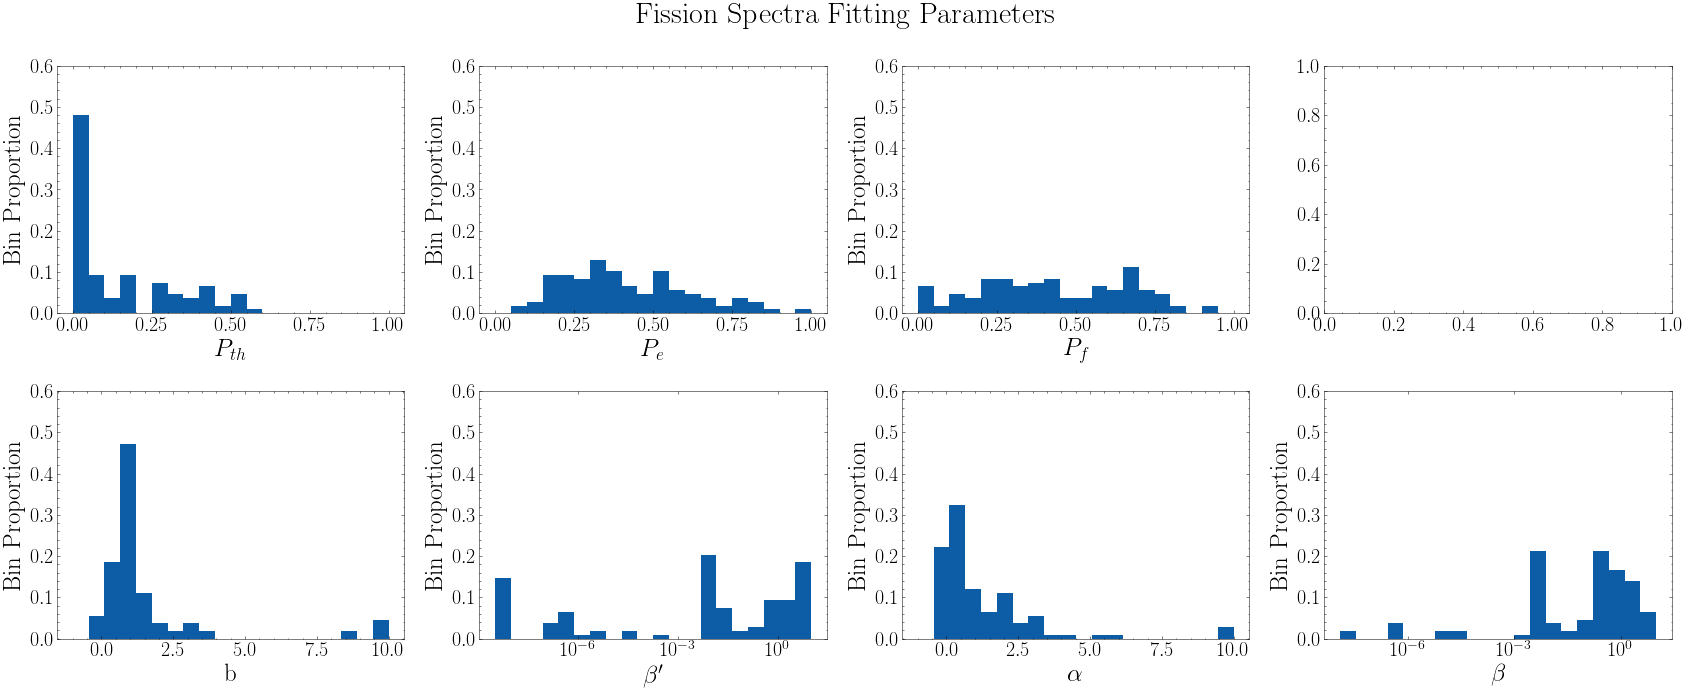

In [8]:
fig, axs = plt.subplots(2,4, figsize=(24,10))
BINS = 20

YMAX = 0.6

plot_hist(axs[0][0], P_th_fission, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("$P_{th}$", fontsize = 25, fontweight = "bold")
axs[0][0].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

plot_hist(axs[0][1], P_e_fission, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("$P_{e}$", fontsize = 25, fontweight = "bold")
axs[0][1].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

P_f_fission = np.ones(len(P_th_fission)) - (np.array(P_th_fission) + np.array(P_e_fission))
plot_hist(axs[0][2], P_f_fission, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("$P_{f}$", fontsize = 25, fontweight = "bold")
axs[0][2].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

plot_hist(axs[1][0], b_fission, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b", fontsize = 25, fontweight = "bold")
axs[1][0].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][1], beta_p_fission, bins = BINS)
axs[1][1].set_xlabel(r"$\beta'$", fontsize = 25, fontweight = "bold")
axs[1][1].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

plot_hist(axs[1][2], alpha_fission, bins = BINS, range = (-1, 10))
axs[1][2].set_xlabel(r"$\alpha$", fontsize = 25, fontweight = "bold")
axs[1][2].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][3], beta_fission, bins = BINS)
axs[1][3].set_xlabel(r"$\beta$", fontsize = 25, fontweight = "bold")
axs[1][3].set_ylabel("Bin Proportion", fontsize = 25, fontweight = "bold")

fig.suptitle("Fission Spectra Fitting Parameters", fontsize = 30, fontweight = "bold")
plt.tight_layout()

plt.savefig("FissionParams.png", dpi = 300)


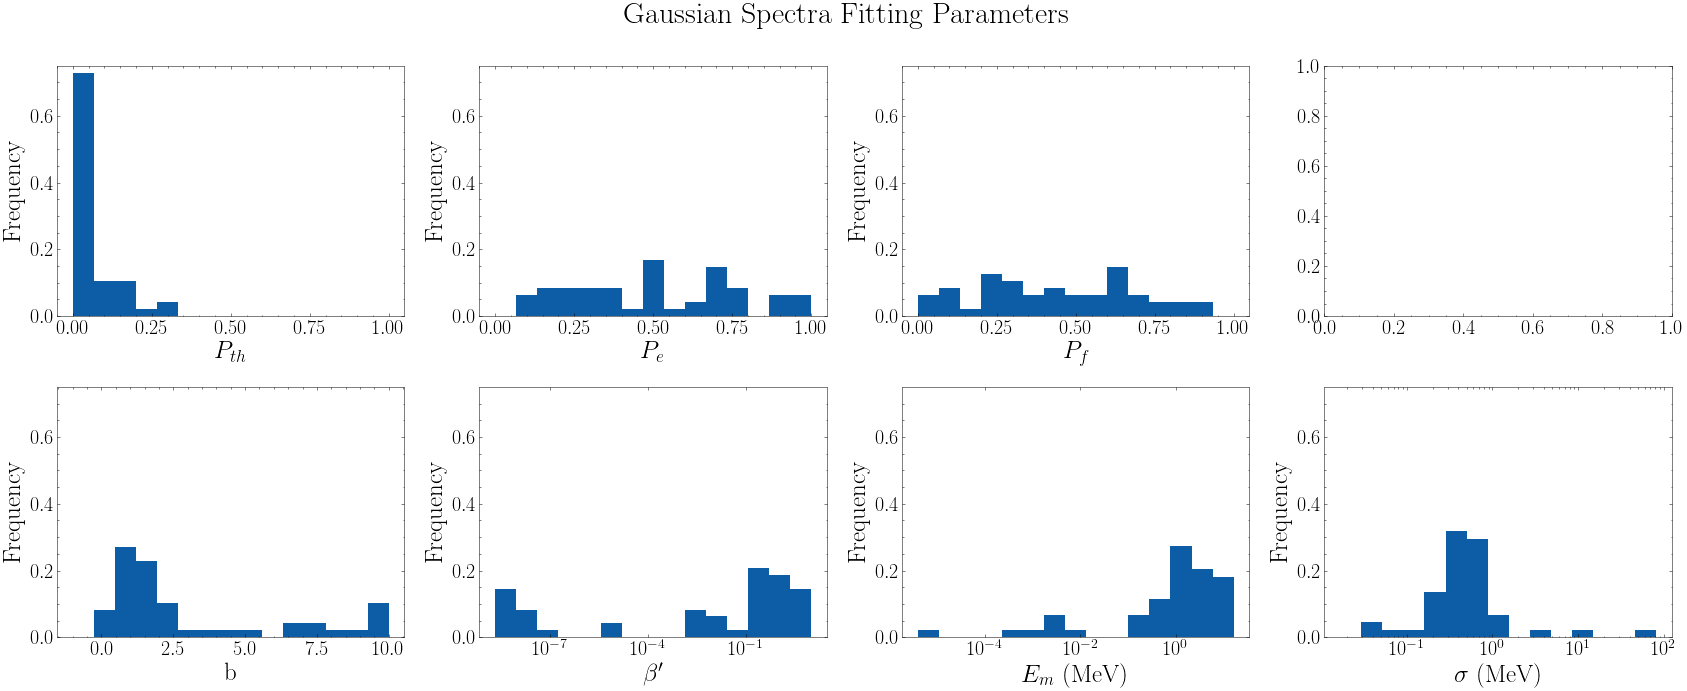

In [9]:
fig, axs = plt.subplots(2,4, figsize=(24,10))
BINS = 15
YMAX = 0.75

plot_hist(axs[0][0], P_th_gauss, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("$P_{th}$", fontsize = 25, fontweight = "bold")
axs[0][0].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_hist(axs[0][1], P_e_gauss, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("$P_{e}$", fontsize = 25, fontweight = "bold")
axs[0][1].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

P_f_gauss = np.ones(len(P_e_gauss)) - (np.array(P_th_gauss) + np.array(P_e_gauss))
plot_hist(axs[0][2], P_f_gauss, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("$P_{f}$", fontsize = 25, fontweight = "bold")
axs[0][2].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_hist(axs[1][0], b_gauss, bins = BINS, range = (-1, 10))
#axs[1][0].hist(b_gauss, bins = BINS, range = (0, 2))
axs[1][0].set_xlabel("b", fontsize = 25, fontweight = "bold")
axs[1][0].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][1], beta_p_gauss, bins = BINS)
#axs[1][1].hist(beta_p_gauss, bins = BINS, range = (0, 2))
axs[1][1].set_xlabel(r"$\beta'$", fontsize = 25, fontweight = "bold")
axs[1][1].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][2], E_m_gauss, bins = BINS)
#axs[1][2].hist(E_m_gauss, bins = BINS, range = (0, 100))
axs[1][2].set_xlabel(r"$E_m$ (MeV)", fontsize = 25, fontweight = "bold")
axs[1][2].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][3], sigma_gauss, bins = BINS)
#axs[1][3].hist(sigma_gauss, bins = BINS, range = (0, 100))
axs[1][3].set_xlabel(r"$\sigma$ (MeV)", fontsize = 25, fontweight = "bold")
axs[1][3].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

fig.suptitle("Gaussian Spectra Fitting Parameters", fontsize = 30, fontweight = "bold")
plt.tight_layout()

plt.savefig("GaussianParams.png", dpi = 300)


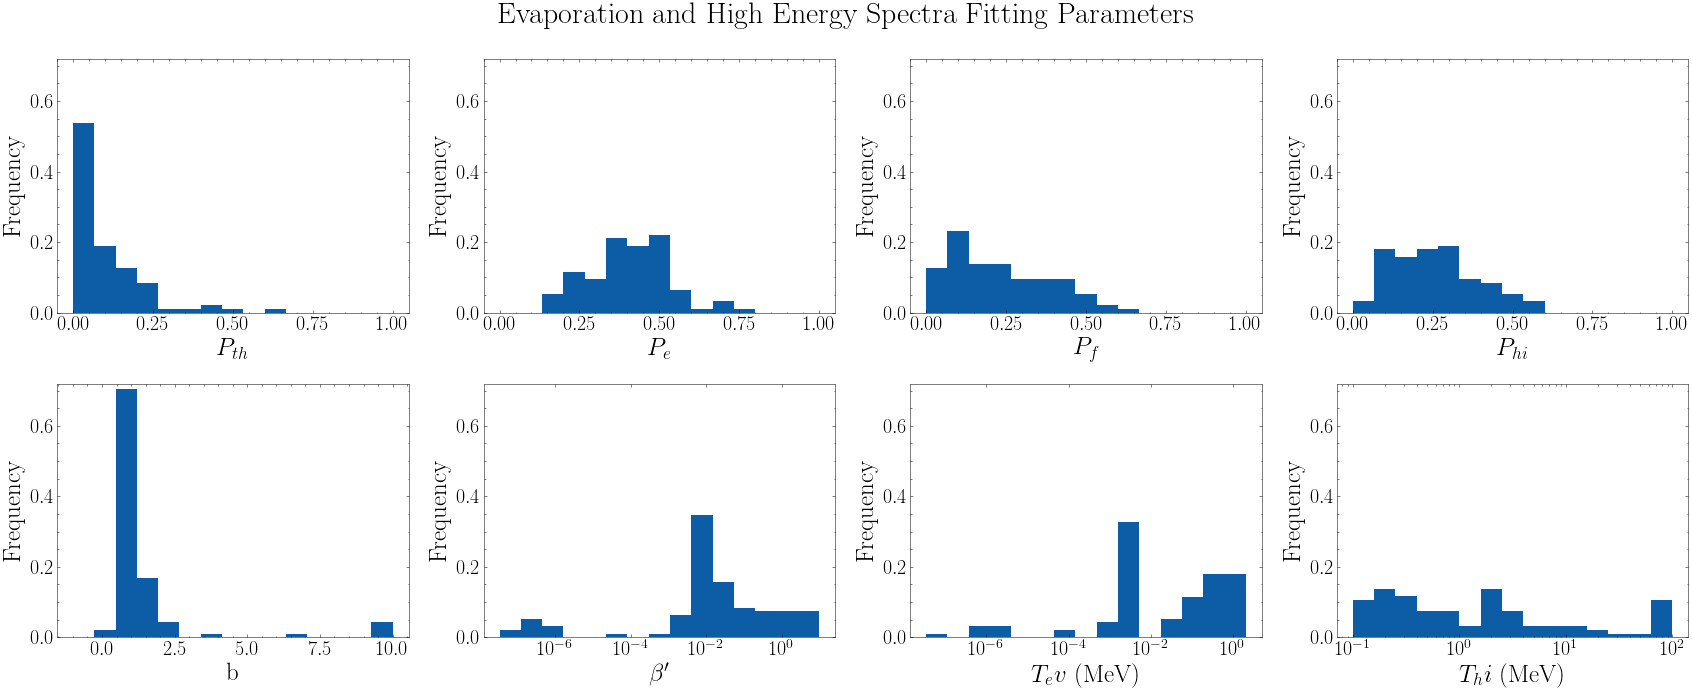

In [10]:
fig, axs = plt.subplots(2,4, figsize=(24,10))
BINS = 15
YMAX = 0.72

plot_hist(axs[0][0], P_th_high_energy, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("$P_{th}$", fontsize = 25, fontweight = "bold")
axs[0][0].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_hist(axs[0][1], P_e_high_energy, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("$P_{e}$", fontsize = 25, fontweight = "bold")
axs[0][1].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_hist(axs[0][2], P_f_high_energy, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("$P_{f}$", fontsize = 25, fontweight = "bold")
axs[0][2].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

P_hi_high_energy = np.ones(len(P_f_high_energy)) - (np.array(P_th_high_energy) + np.array(P_e_high_energy) + np.array(P_f_high_energy))
plot_hist(axs[0][3], P_hi_high_energy, bins = BINS, range = (0,1))
axs[0][3].set_xlabel("$P_{hi}$", fontsize = 25, fontweight = "bold")
axs[0][3].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_hist(axs[1][0], b_high_energy, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b", fontsize = 25, fontweight = "bold")
axs[1][0].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][1], beta_p_high_energy, bins = BINS)
axs[1][1].set_xlabel(r"$\beta'$", fontsize = 25, fontweight = "bold")
axs[1][1].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][2], T_ev_high_energy, bins = BINS)
axs[1][2].set_xlabel(r"$T_ev$ (MeV)", fontsize = 25, fontweight = "bold")
axs[1][2].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

plot_loghist(axs[1][3], T_hi_high_energy, bins = BINS)
axs[1][3].set_xlabel(r"$T_hi$ (MeV)", fontsize = 25, fontweight = "bold")
axs[1][3].set_ylabel("Frequency", fontsize = 25, fontweight = "bold")

fig.suptitle("Evaporation and High Energy Spectra Fitting Parameters", fontsize = 30, fontweight = "bold")
plt.tight_layout()

plt.savefig("EvapHighEnergyParams.png", dpi = 300)


# 1st evaluation of each data generation algorithm's performance
#### - Fully train neural network on data from algorithm
#### - Unfold IAEA data it has never seen before, log performance

In [10]:
trials = 30

def evaluate(args):
    algorithm, params, name = args
    
    benchmark = []
    benchmark_dev = []
    models = []
    
    data_points = 3000
    xdata, ydata = algorithm(data_points, yother)
    
    boot = ShuffleSplit(n_splits = trials, test_size = 0.1)
    trial = 0
    for train, test in boot.split(xdata):
        
        trial += 1
        
        xtrain, ytrain = xdata[train], ydata[train]
        xtest, ytest = xdata[test], ydata[test]
        
        print("Starting {} : trial {} ...".format(name, trial))
        
        model = unfolding_network.generate_model(**params)
        
        model.compile(loss = "mse", optimizer = Adam(learning_rate=0.001))
        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10,
                                patience=20, verbose=0, mode='min',
                                restore_best_weights=True)
        
        model.fit(xtrain,ytrain,validation_data=(xtest,ytest),
                  callbacks=[monitor],verbose=0,epochs=100000,
                  batch_size=int(constants.OPT_PARAMS_UNFOLD["batch_size"]))
        
        ypred = model.predict(xeval)
        
        score = np.mean( (yeval - ypred)**2 )
        
        benchmark.append(score)
        
        benchmark_dev.append(np.std([np.mean( (yeval[i] - ypred[i])**2 ) for i in range(len(yeval))]))
        
        models.append(model)
    
    return np.mean(benchmark), np.mean(benchmark_dev), models
    
    
    

In [11]:
PSA = data_generation.PSA
RAND = data_generation.RAND

GAUSS = data_generation.GAUSS
GAUSS_LINEAR = data_generation.GAUSS_LINEAR

GAUSS_SKEW = data_generation.GAUSS_SKEW
GAUSS_SKEW_LINEAR = data_generation.GAUSS_SKEW_LINEAR

FRUIT = data_generation.FRUIT

modelsPSA = None
modelsRAND = None
modelsGAUSS = None
modelsGAUSS_LINEAR = None
modelsGAUSS_SKEW = None
modelsGAUSS_SKEW_LINEAR = None
modelsFRUIT = None

In [7]:
from multiprocessing.dummy import Pool as ThreadPool

def save_models(arg):
    loc, models, name = arg
    i = 0
    for model in models:
        model.save("./NeutronSpectraGeneration/saved_networks/"+loc+"/"+name+str(i))
        i += 1
        
def save_all_models(loc):
    pool = ThreadPool(7)
    pool.map(save_models,  [(loc, modelsPSA, "PSA"), 
                            (loc, modelsRAND, "RAND"), 
                            (loc, modelsGAUSS, "GAUSS"),
                            (loc, modelsGAUSS_LINEAR, "GAUSS_LINEAR"),
                            (loc, modelsGAUSS_SKEW, "GAUSS_SKEW"),
                            (loc, modelsGAUSS_SKEW_LINEAR, "GAUSS_SKEW_LINEAR"),
                            (loc, modelsFRUIT, "FRUIT")])


def load_models(arg):
    loc, name = arg
    models = []
    
    def filter_for_name(filename):
        result = ''.join([i for i in filename if not i.isdigit()])
        return result == name
    
    for file in filter(filter_for_name, os.listdir("./NeutronSpectraGeneration/saved_networks/"+loc+"/")):
        models.append(tf.keras.models.load_model("./NeutronSpectraGeneration/saved_networks/"+loc+"/"+file))
        
    return models
        
def load_all_models(loc):
    global modelsPSA
    global modelsRAND
    global modelsGAUSS
    global modelsGAUSS_LINEAR
    global modelsGAUSS_SKEW
    global modelsGAUSS_SKEW_LINEAR
    global modelsFRUIT
    pool = ThreadPool(7)
    
    results = pool.map(load_models,  [(loc, "PSA"), 
                                      (loc, "RAND"), 
                                      (loc, "GAUSS"),
                                      (loc, "GAUSS_LINEAR"),
                                      (loc, "GAUSS_SKEW"),
                                      (loc, "GAUSS_SKEW_LINEAR"),
                                      (loc, "FRUIT")])
    
    modelsPSA = results[0]
    modelsRAND = results[1]
    modelsGAUSS = results[2]
    modelsGAUSS_LINEAR = results[3]
    modelsGAUSS_SKEW = results[4]
    modelsGAUSS_SKEW_LINEAR = results[5]
    modelsFRUIT = results[6]
    
        
def delete_models(loc, name):
    for file in filter(lambda x : name in x, os.listdir("./NeutronSpectraGeneration/saved_networks/"+loc+"/")):
        shutil.rmtree("./NeutronSpectraGeneration/saved_networks/"+loc+"/"+file)

def delete_all_models(loc):
    delete_models(loc, "PSA")
    delete_models(loc, "RAND")
    delete_models(loc, "GAUSS")
    delete_models(loc, "GAUSS_LINEAR")
    delete_models(loc, "GAUSS_SKEW")
    delete_models(loc, "GAUSS_SKEW_LINEAR")
    delete_models(loc, "FRUIT")
    
def train_networks():
    global modelsPSA
    global modelsRAND
    global modelsGAUSS
    global modelsGAUSS_LINEAR
    global modelsGAUSS_SKEW
    global modelsGAUSS_SKEW_LINEAR
    global modelsFRUIT
    
    pool = ThreadPool(7)

    results = pool.map(evaluate, [(PSA, constants.OPT_PARAMS_UNFOLD, "PSA"), 
                                  (RAND, constants.OPT_PARAMS_UNFOLD, "RAND"), 
                                  (GAUSS, constants.OPT_PARAMS_UNFOLD, "GAUSS"),
                                  (GAUSS_LINEAR, constants.OPT_PARAMS_UNFOLD, "GAUSS_LINEAR"),
                                  (GAUSS_SKEW, constants.OPT_PARAMS_UNFOLD, "GAUSS_SKEW"),
                                  (GAUSS_SKEW_LINEAR, constants.OPT_PARAMS_UNFOLD, "GAUSS_SKEW_LINEAR"),
                                  (FRUIT, constants.OPT_PARAMS_UNFOLD, "FRUIT")])

    meanPSA, stdPSA, modelsPSA = results[0]
    meanRAND, stdRAND, modelsRAND = results[1]
    meanGAUSS, stdGAUSS, modelsGAUSS = results[2]
    meanGAUSS_LINEAR, stdGAUSS_LINEAR, modelsGAUSS_LINEAR = results[3]
    meanGAUSS_SKEW, stdGAUSS_SKEW, modelsGAUSS_SKEW = results[4]
    meanGAUSS_SKEW_LINEAR, stdGAUSS_SKEW_LINEAR, modelsGAUSS_SKEW_LINEAR = results[5]
    meanFRUIT, stdFRUIT, modelsFRUIT = results[6]
    
    print("PSA: {:e} ± {:e}".format(meanPSA, stdPSA))
    print("FRUIT: {:e} ± {:e}".format(meanFRUIT, stdFRUIT))
    print("GAUSS_LINEAR: {:e} ± {:e}".format(meanGAUSS_LINEAR, stdGAUSS_LINEAR))
    print("GAUSS_SKEW_LINEAR: {:e} ± {:e}".format(meanGAUSS_SKEW_LINEAR, stdGAUSS_SKEW_LINEAR))
    print("GAUSS_SKEW: {:e} ± {:e}".format(meanGAUSS_SKEW, stdGAUSS_SKEW))
    print("GAUSS: {:e} ± {:e}".format(meanGAUSS, stdGAUSS))
    print("RAND: {:e} ± {:e}".format(meanRAND, stdRAND))
    

def unfolding_MSE(models):
    MSEs = []
    MSEs_STD = []
    for model in models:
        ypred = model.predict(xeval)
        sq_err = (yeval - ypred)**2
        MSEs.append(np.mean(sq_err))
        MSEs_STD.append(np.std([np.mean(row) for row in sq_err]))
    return np.mean(MSEs), np.mean(MSEs_STD)

def unfolding_NMSE(models):
    MSEs = []
    MSEs_STD = []
    for model in models:
        MSE = []
        ypred = model.predict(xeval)
        i = 0
        for y in yeval:
            MSE.append( (yeval[i] - ypred[i])**2 / np.max(yeval[i])**2 )
        MSEs.append(np.mean(MSE))
        MSEs_STD.append(np.std(MSE))
    return np.mean(MSEs), np.mean(MSEs_STD)
        


In [8]:
"""
with tf.device('/device:CPU:0'):
    train_networks()
save_all_models("linearTwoLayer")
"""
# last time it was ran this was printed
print(
"""
For two layer network w/ Linear:

PSA: 1.735558e-04 ± 3.070618e-04
FRUIT: 1.921136e-04 ± 4.270521e-04
GAUSS_LINEAR: 2.578796e-04 ± 4.890078e-04
GAUSS_SKEW_LINEAR: 2.136489e-04 ± 4.160505e-04
GAUSS_SKEW: 2.511723e-04 ± 4.506189e-04
GAUSS: 3.422955e-04 ± 6.112616e-04
RAND: 5.831033e-04 ± 8.391047e-04
"""
)

# Since the best performance was for GAUSS_LINEAR and GAUSS_SKEW_LINEAR those will be
# taken as the default "Gauss" and "Gauss-skew" since they are the exact same data generation
# as GAUSS and GAUSS_SKEW, just with obviously better choice of hyperparams
# (unless otherwise specified)


For two layer network w/ Linear:

PSA: 1.735558e-04 ± 3.070618e-04
FRUIT: 1.921136e-04 ± 4.270521e-04
GAUSS_LINEAR: 2.578796e-04 ± 4.890078e-04
GAUSS_SKEW_LINEAR: 2.136489e-04 ± 4.160505e-04
GAUSS_SKEW: 2.511723e-04 ± 4.506189e-04
GAUSS: 3.422955e-04 ± 6.112616e-04
RAND: 5.831033e-04 ± 8.391047e-04



In [9]:
load_all_models("linearTwoLayer")

In [10]:

# Re-test MSE Data to Confirm
print("PSA: {:e} ± {:e}".format(*unfolding_MSE(modelsPSA)))
print("FRUIT: {:e} ± {:e}".format(*unfolding_MSE(modelsFRUIT)))
print("GAUSS_LINEAR: {:e} ± {:e}".format(*unfolding_MSE(modelsGAUSS_LINEAR)))
print("GAUSS_SKEW_LINEAR: {:e} ± {:e}".format(*unfolding_MSE(modelsGAUSS_SKEW_LINEAR)))
print("GAUSS_SKEW: {:e} ± {:e}".format(*unfolding_MSE(modelsGAUSS_SKEW)))
print("GAUSS: {:e} ± {:e}".format(*unfolding_MSE(modelsGAUSS)))
print("RAND: {:e} ± {:e}".format(*unfolding_MSE(modelsRAND)))



PSA: 1.735558e-04 ± 3.070618e-04
FRUIT: 1.921136e-04 ± 4.270521e-04
GAUSS_LINEAR: 2.578796e-04 ± 4.890078e-04
GAUSS_SKEW_LINEAR: 2.136489e-04 ± 4.160505e-04
GAUSS_SKEW: 2.511723e-04 ± 4.506189e-04
GAUSS: 3.422955e-04 ± 6.112616e-04
RAND: 5.831033e-04 ± 8.391047e-04


# All Figures showing Example Spectra

In [13]:
def plot_unfolded(ax, spectra, yerr = None, color = "blue", label = "unfolded", alpha = 0.8):
    ax.step(constants.Ebins, spectra, color = color, label = label, alpha = alpha, where = "mid", linewidth = 4)
    if yerr is not None:
        ax.errorbar(constants.Ebins, spectra, yerr = yerr, fmt = "none", ecolor = "black", elinewidth = 1, capsize = 2)
    ax.set_xscale("log")




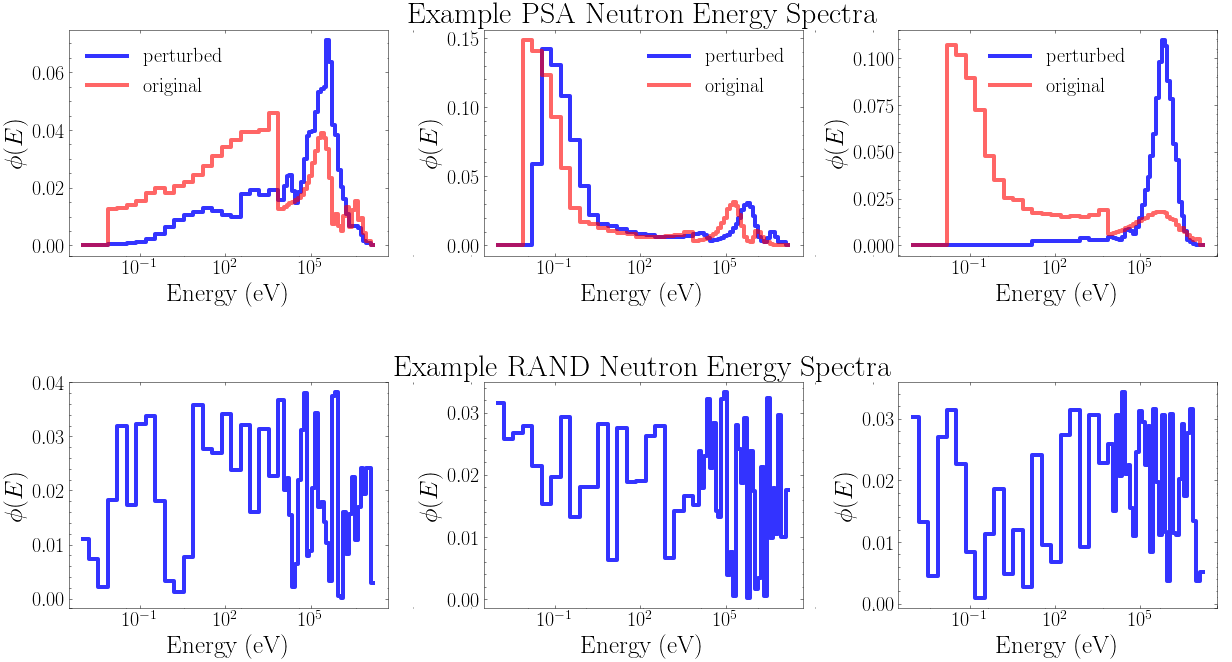

In [14]:
# PSA and RAND

fig, axs = subplots_with_row_titles(2, 3, row_title_kw={'fontsize': 30, 'weight': "bold"}, row_titles = ["Example PSA Neutron Energy Spectra", "Example RAND Neutron Energy Spectra"], figsize = (18, 10))

x,y,originals = data_generation.perturb_spectra_algorithm(constants.OPT_PARAMS_PSA["stretch_sigma"], yother, 10, True)
np.random.shuffle(y)

for i in range(3):
    plot_unfolded(axs[0][i], y[i], label = "perturbed")
    plot_unfolded(axs[0][i], originals[i], color = "red", label = "original", alpha = 0.6)
    axs[0][i].set_xscale("log")
    axs[0][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[0][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")
    axs[0][i].legend()
    
x,y = RAND(10, [])
np.random.shuffle(y)

for i in range(3):
    plot_unfolded(axs[1][i], y[i])
    axs[1][i].set_xscale("log")
    axs[1][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[1][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")

plt.tight_layout()
plt.savefig("examplePSAandRAND", dpi=300)


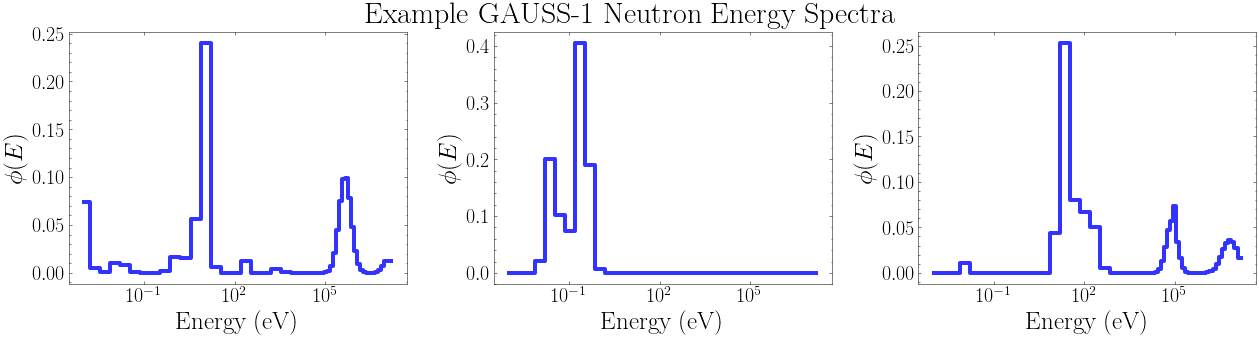

In [17]:
# GAUSS

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

x,y = GAUSS_LINEAR(10, [])
np.random.shuffle(y)

for i in range(3):
    plot_unfolded(axs[i], y[i])
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")

plt.suptitle("Example GAUSS-1 Neutron Energy Spectra", fontsize = 30, fontweight = "bold")

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig("exampleGAUSS1", dpi = 300)


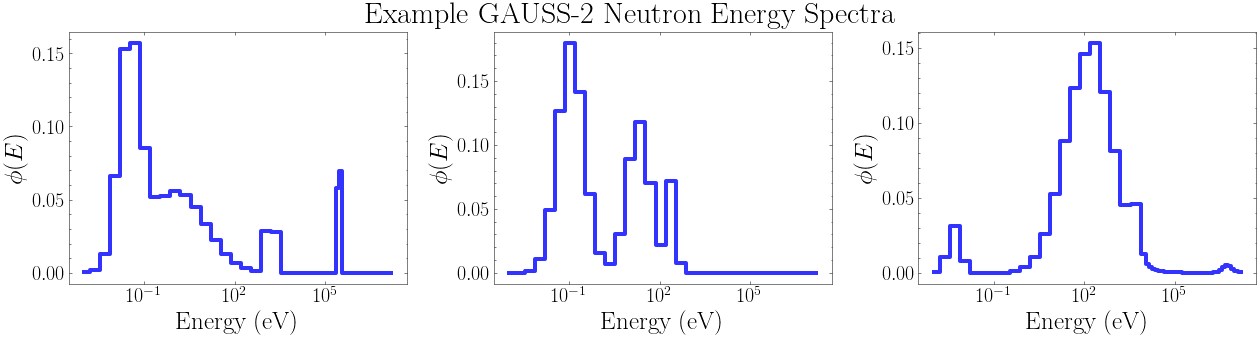

In [18]:
# GAUSS-SKEWED

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

x,y = GAUSS_SKEW_LINEAR(10, [])
np.random.shuffle(y)

for i in range(3):
    plot_unfolded(axs[i], y[i])
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")

plt.suptitle("Example GAUSS-2 Neutron Energy Spectra", fontsize = 30, fontweight = "bold")

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig("exampleGAUSS2", dpi = 300)


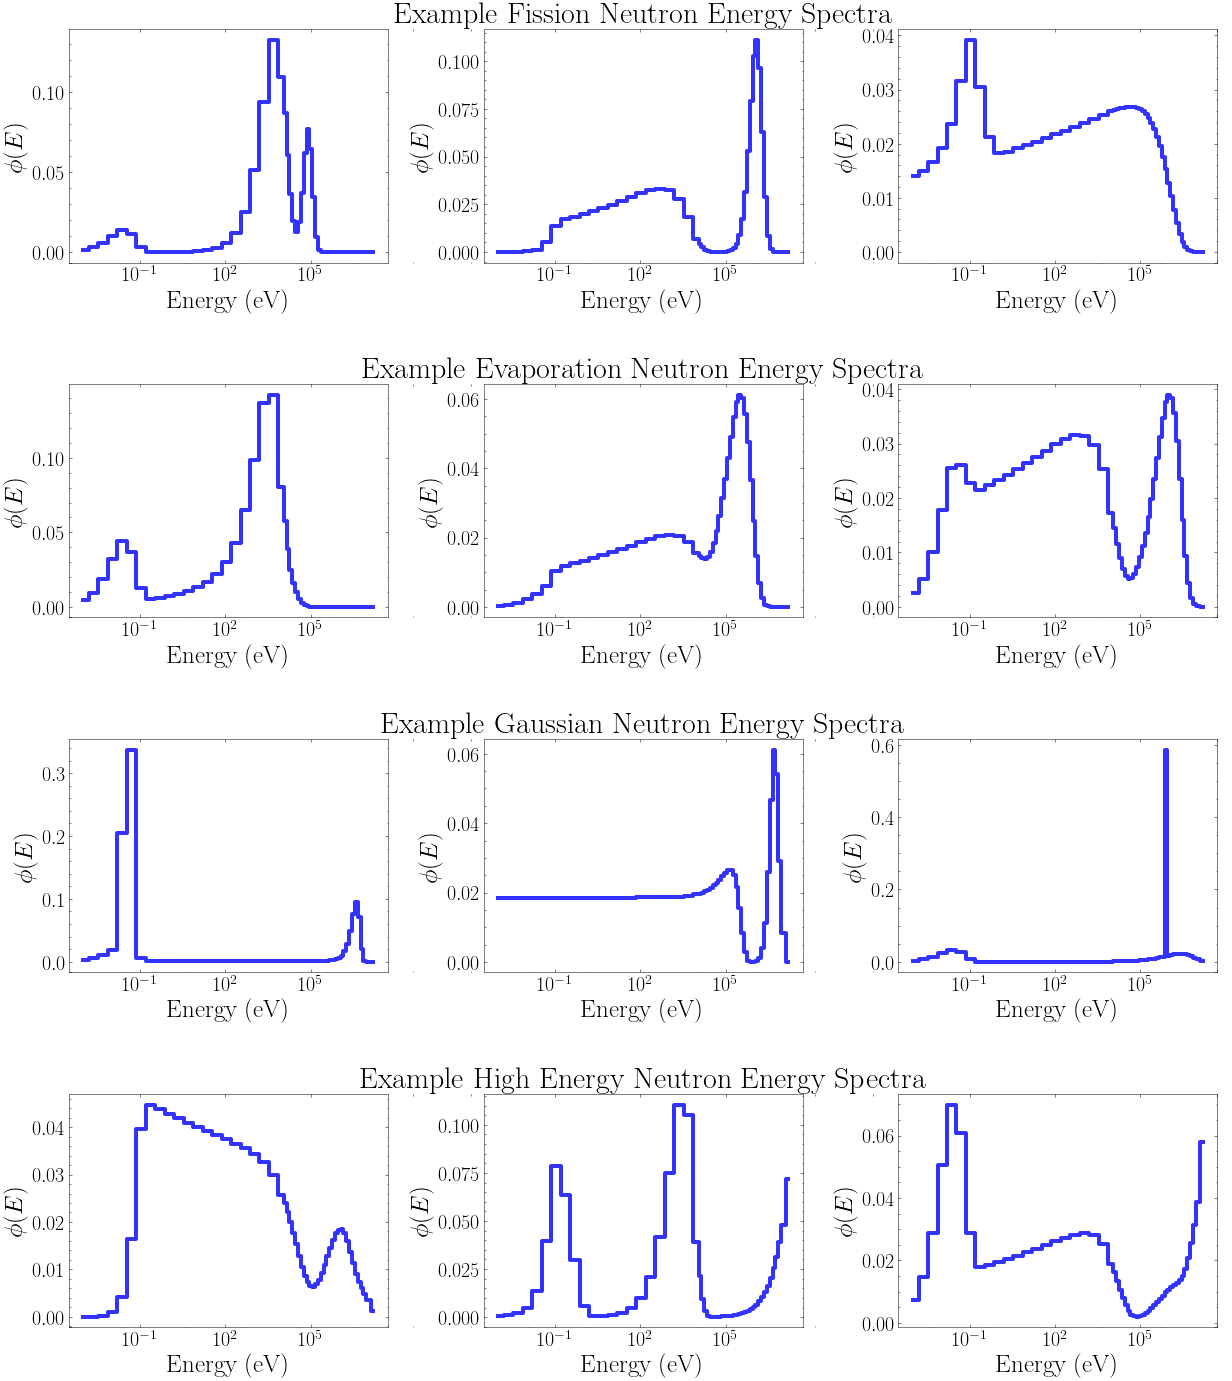

In [44]:
# FRUIT
import fruit_spectra

fig, axs = subplots_with_row_titles(4, 3, row_title_kw={'fontsize': 30, 'weight': "bold"}, row_titles = ["Example Fission Neutron Energy Spectra", "Example Evaporation Neutron Energy Spectra", "Example Gaussian Neutron Energy Spectra", "Example High Energy Neutron Energy Spectra"], figsize = (18, 20))

for i in range(3):
    plot_unfolded(axs[0][i], fruit_spectra.randFission())
    axs[0][i].set_xscale("log")
    axs[0][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[0][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")

for i in range(3):
    plot_unfolded(axs[1][i], fruit_spectra.randEvap())
    axs[1][i].set_xscale("log")
    axs[1][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[1][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")
    
for i in range(3):
    plot_unfolded(axs[2][i], fruit_spectra.randGauss())
    axs[2][i].set_xscale("log")
    axs[2][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[2][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")
    
for i in range(3):
    plot_unfolded(axs[3][i], fruit_spectra.randHighEnergy())
    axs[3][i].set_xscale("log")
    axs[3][i].set_xlabel("Energy (eV)", fontsize = 25, fontweight = "bold")
    axs[3][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")

plt.tight_layout()

plt.savefig("exampleFRUIT", dpi = 300)


# Evaluating Equivalent Neutron Dose Vector

In [11]:
# from IAEA Techdoc, Table 2.III, Column 2
doseEquiv = np.array([6.75e0, 7.29e0, 8.29e0, 9.78e0, 
                     1.06e1, 1.27e1, 1.34e1, 1.26e1,
                     1.31e1, 1.29e1, 1.26e1, 1.16e1,
                     1.10e1, 1.04e1, 9.93e0, 9.26e0,
                     8.77e0, 8.25e0, 7.85e0, 7.98e0,
                     8.69e0, 1.13e1, 1.28e1, 1.51e1,
                     1.82e1, 2.23e1, 2.80e1, 3.61e1,
                     4.69e1, 6.07e1, 7.81e1, 9.91e1,
                     1.24e2, 1.54e2, 1.86e2, 2.22e2,
                     2.61e2, 3.02e2, 3.42e2, 3.76e2,
                     3.98e2, 4.27e2, 4.14e2, 3.97e2,
                     4.13e2, 4.13e2, 4.09e2, 4.06e2,
                     4.01e2, 4.05e2, 4.18e2, 4.91e2,
                     5.96e2])

#Multiply by lethargy interval to get group fluences
lethargy = np.log(np.append(constants.Ebins[1:], [2.51E+07])) - np.log(constants.Ebins)

scaling = None
def get_doses(y, scale = True):
    doses = np.zeros(y.shape[0])
    i = 0
    for row in y:
        yfluence = lethargy * row
        if scale:
            yfluence *= scaling[i]
        doses[i] = np.matmul(doseEquiv, yfluence)
        i += 1

    return np.array(doses)
scaling = (100 / get_doses(yeval, scale = False))

In [12]:
def getDosePerformance(models):
    doseActual = get_doses(yeval)
    
    meanDoseErr = []
    stdDoseErr = []
    meanDosePercErr = []
    stdDosePercErr = []
    for model in models:
        ypred = model(xeval)
        dosePred = get_doses(ypred)
        meanDoseErr.append( np.mean( np.abs( (doseActual - dosePred) ) ) )
        stdDoseErr.append( np.std( np.abs( (doseActual - dosePred) ) ) )
        
        meanDosePercErr.append(np.mean( np.abs( (doseActual - dosePred) / doseActual ) ) )
        stdDosePercErr.append(np.std( np.abs( (doseActual - dosePred) / doseActual ) ) )

    return np.mean(meanDoseErr), np.mean(stdDoseErr), 100 * np.mean(meanDosePercErr), 100 * np.mean(stdDosePercErr)



In [13]:
print("PSA Dose Absolute Error : {:.2f} ± {:.2f} uSv ; Percent Error : {:.1f} ± {:.1f} %".format(*getDosePerformance(modelsPSA)))
print("GAUSS-1 Dose Absolute Error : {:.2f} ± {:.2f} uSv ; Percent Error : {:.1f} ± {:.1f} %".format(*getDosePerformance(modelsGAUSS_LINEAR)))
print("GAUSS-2 Dose Absolute Error : {:.2f} ± {:.2f} uSv ; Percent Error : {:.1f} ± {:.1f} %".format(*getDosePerformance(modelsGAUSS_SKEW_LINEAR)))
print("FRUIT Dose Absolute Error : {:.2f} ± {:.2f} uSv ; Percent Error : {:.1f} ± {:.1f} %".format(*getDosePerformance(modelsFRUIT)))
print("RAND Dose Absolute Error : {:.2f} ± {:.2f} uSv ; Percent Error : {:.1f} ± {:.1f} %".format(*getDosePerformance(modelsRAND)))




PSA Dose Absolute Error : 7.88 ± 9.17 uSv ; Percent Error : 7.9 ± 9.2 %
GAUSS-1 Dose Absolute Error : 11.59 ± 10.89 uSv ; Percent Error : 11.6 ± 10.9 %
GAUSS-2 Dose Absolute Error : 8.31 ± 7.58 uSv ; Percent Error : 8.3 ± 7.6 %
FRUIT Dose Absolute Error : 7.07 ± 7.04 uSv ; Percent Error : 7.1 ± 7.0 %
RAND Dose Absolute Error : 60.84 ± 84.13 uSv ; Percent Error : 60.8 ± 84.1 %


# Showing Best and Worst Spectra for Each Model

In [14]:
def best_and_worst_plot(models, name):
    
    # Get average MSE per spectra across all models
    MSEs = np.zeros(yeval.shape[0])
    for model in models:
        ypred = model(xeval)
        sq_err = (yeval - ypred)**2
        MSEs += np.array([np.mean(sq_err[i]) for i in range(sq_err.shape[0])])
    MSEs /= len(models)
    
    ypredALL = []
    for model in models:
        ypredALL.append(model(xeval))
    ypredALL = np.array(ypredALL)
    
    ypredAVG = np.mean(ypredALL, axis = 0)
    ypredSTD = np.std(ypredALL, axis = 0)
    
    # Find N best and worst spectra
    N = 3

    tmp = list(MSEs)

    MSEs.sort()

    best = MSEs[:N]
    worst = MSEs[-N:]
    best.sort()
    worst.sort()

    bestIndex = []
    for mse in best:
        bestIndex.append(tmp.index(mse))
    worstIndex = []
    for mse in worst:
        worstIndex.append(tmp.index(mse))
      
    # Create plots
    fig, axs = subplots_with_row_titles(2, len(bestIndex), row_title_kw={'fontsize': 30, 'weight': "bold"}, row_titles = ["IAEA Spectra w/ Minimum Unfolding Error, " + name, "IAEA Spectra w/ Maximum Unfolding Error, " + name], figsize = (18, 10))

    for i in range(len(bestIndex)):
        plot_unfolded(axs[0][i], yeval[bestIndex[i]], label = "Actual", color = "orange")
        plot_unfolded(axs[0][i], ypredAVG[bestIndex[i]], label = "Unfolded")
        axs[0][i].set_xscale("log")
        axs[0][i].set_xlabel("Neutron Energy (eV)", fontsize = 25, fontweight = "bold")
        axs[0][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")
        axs[0][i].legend(fontsize = 18)

    for i in range(len(worstIndex)):
        plot_unfolded(axs[1][i], yeval[worstIndex[i]], label = "Actual", color = "orange")
        plot_unfolded(axs[1][i], ypredAVG[worstIndex[i]], label = "Unfolded")
        axs[1][i].set_xscale("log")
        axs[1][i].set_xlabel("Neutron Energy (eV)", fontsize = 25, fontweight = "bold")
        axs[1][i].set_ylabel("$\phi(E)$", fontsize = 25, fontweight = "bold")
        axs[1][i].legend(fontsize = 18)

    plt.tight_layout()


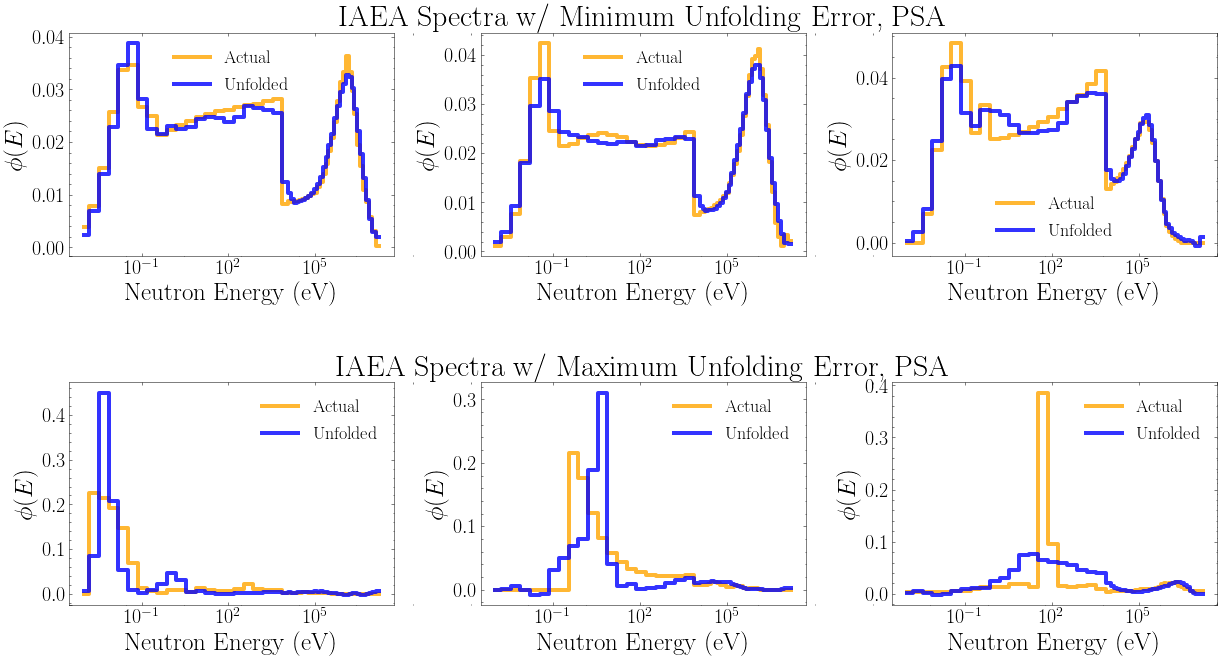

In [49]:
best_and_worst_plot(modelsPSA, "PSA")
plt.savefig("bestworstPSA", dpi = 300)

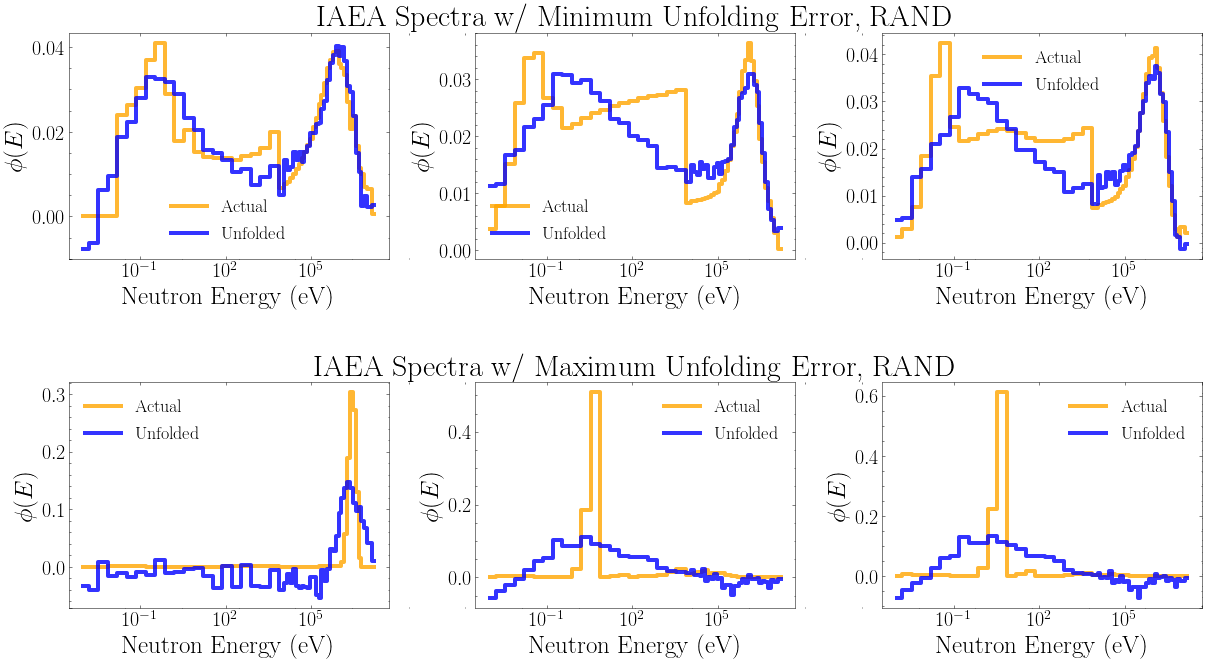

In [50]:
best_and_worst_plot(modelsRAND, "RAND")
plt.savefig("bestworstRAND", dpi = 300)

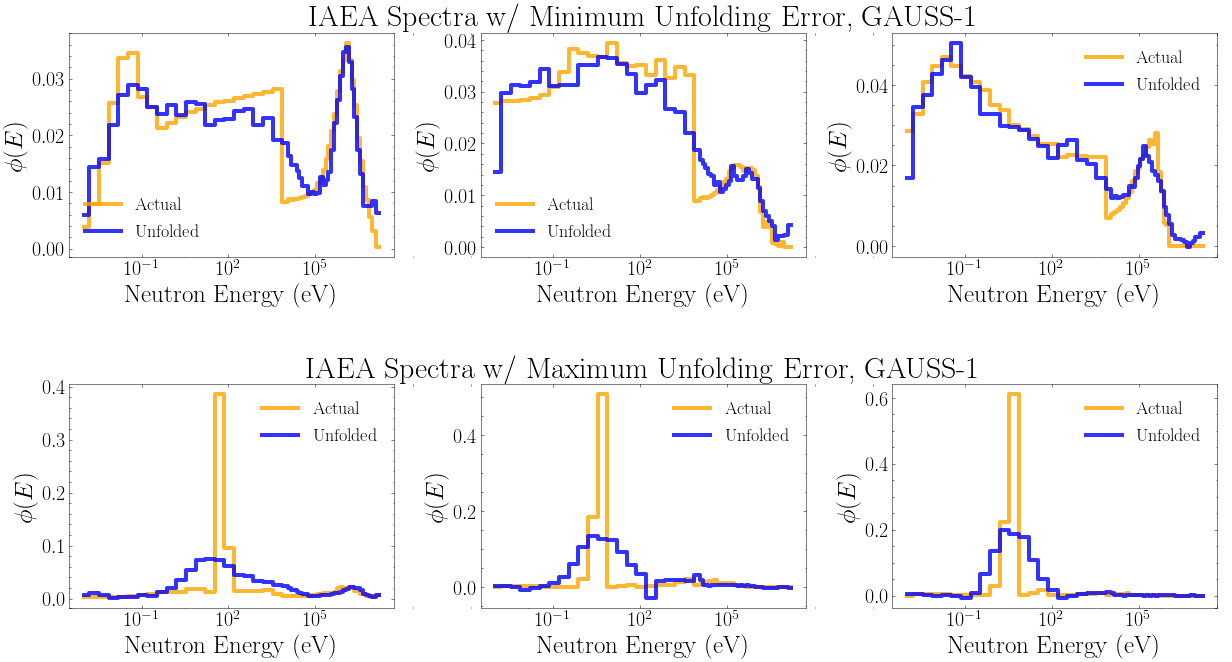

In [51]:
best_and_worst_plot(modelsGAUSS_LINEAR, "GAUSS-1")
plt.savefig("bestworstGAUSS-1", dpi = 300)

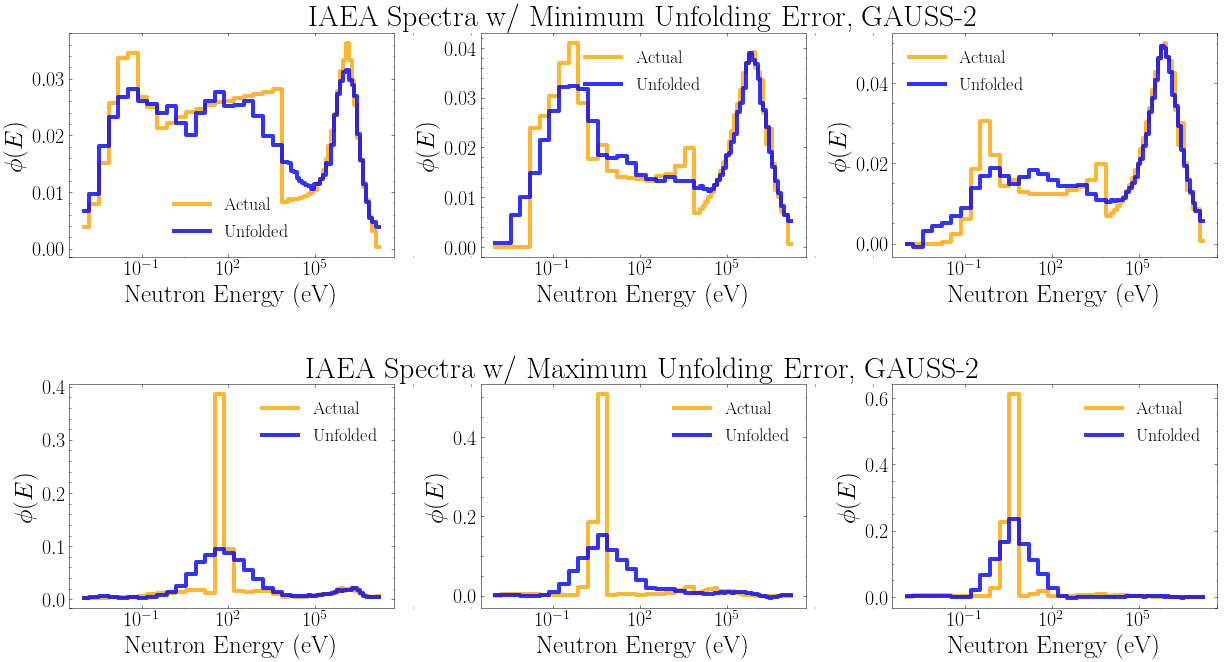

In [52]:
best_and_worst_plot(modelsGAUSS_SKEW_LINEAR, "GAUSS-2")
plt.savefig("bestworstGAUSS-2", dpi = 300)

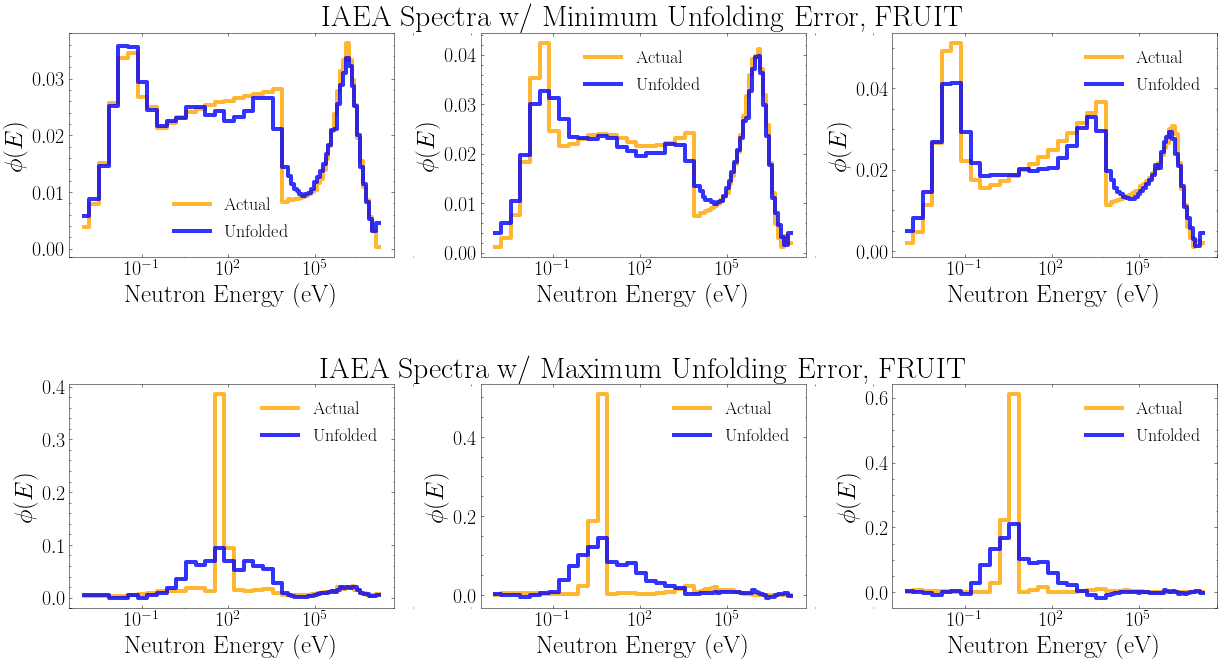

In [53]:
best_and_worst_plot(modelsFRUIT, "FRUIT")
plt.savefig("bestworstFRUIT", dpi = 300)

# Unfolding Performance vs IAEA Spectra Type

In [15]:
# Load IAEA data and visually classify each spectra according to label
import pickle

with open("./NeutronSpectraGeneration/IAEA_data/unfolding_data.pkl", 'rb') as f:
    loaded = pickle.load(f)

for i in range(len(loaded["Spectrum Name"])):
    print(i,loaded["Spectrum Name"][i])
    
print("""
0 -> fission
1 -> moderated fission
2 -> 3 are reference
4 -> 6 are fission
7 -> 14 are moderated fission
15 -> 17 moderated reference
18 -> 20 reference
21 -> 22 moderated reference
23 is reference
24 -> 25 moderated reference
26 -> 28 reference
29 -> 30 moderated reference
31 -> 32 reference
33 -> 36 are moderated fission
37 -> 56 "workplace"
57 -> 60 are fusion
61 -> 63 are fission
64 -> 70 are "stray neutron field"
71 -> 87 are "high energy spectra"
88 -> 150 are "fission"
151 -> 197 are "particle accelerator / cyclotron / microtron / etc"
198 -> 202 are "cosmic ray spectra"
203 -> 237 are "fission"
238 -> 250 are "boron therapy / medical"
""")

0 ISO REFERENCE SPECTRA 
252Cf
1 ISO REFERENCE SPECTRA 
D2O moderated Cf
2 ISO REFERENCE SPECTRA 
Am-Be
3 ISO REFERENCE SPECTRA 
Am-B
4 BARE Cf SPECTRA (PTB) 
Measured without shadow cone
5 BARE Cf SPECTRA (PTB) 
Measured with shadow cone
6 BARE Cf SPECTRA (PTB) 
The difference
7 HEAVY WATER MODERATED Cf SPECTRA (PTB) 
Measured without shadow cone
8 HEAVY WATER MODERATED Cf SPECTRA (PTB) 
Measured with shadow cone
9 HEAVY WATER MODERATED Cf SPECTRA (PTB) 
The difference
10 MODERATED Cf SPECTRA (TOHOKO UNIVERSITY AND JINR) 
Fe moderated Cf
11 MODERATED Cf SPECTRA (TOHOKO UNIVERSITY AND JINR) 
C moderated Cf
12 MODERATED Cf SPECTRA (TOHOKO UNIVERSITY AND JINR) 
PE moderated Cf
13 MODERATED Cf SPECTRA (TOHOKO UNIVERSITY AND JINR) 
PE moderated Cf,D= 29.2 cm
14 MODERATED Cf SPECTRA (TOHOKO UNIVERSITY AND JINR) 
PE moderated Cf,
15 Am-Be SPECTRA (PTB) 
Difference with and without shadow cone
16 Am-Be SPECTRA (PTB) 
Measured with shadow cone
17 Am-Be SPECTRA (PTB) 
Measured without shadow co

In [21]:
spectra_labels = ( (1) * ["fission"] 
                 + (1) * ["moderated fission"] 
                 + (3 - 2 + 1) * ["reference"] 
                 + (6 - 4 + 1) * ["moderated fission"] 
                 + (14 - 7 + 1) * ["moderated fission"] 
                 + (17 - 15 + 1) * ["moderated reference"] 
                 + (20 - 18 + 1) * ["reference"] 
                 + (22 - 21 + 1) * ["moderated reference"] 
                 + (23 - 23 + 1) * ["reference"] 
                 + (25 - 24 + 1) * ["moderated reference"] 
                 + (28 - 26 + 1) * ["reference"] 
                 + (30 - 29 + 1) * ["moderated reference"]  
                 + (32 - 31 + 1) * ["reference"]  
                 + (36 - 33 + 1) * ["moderated reference"]   
                 + (56 - 37 + 1) * ["workplace"] 
                 + (60 - 57 + 1) * ["fusion"] 
                 + (63 - 61 + 1) * ["fission"]
                 + (70 - 64 + 1) * ["workplace"]
                 + (87 - 71 + 1) * ["high energy"]
                 + (150 - 88 + 1) * ["fission"]
                 + (197 - 151 + 1) * ["accelerator"]
                 + (202 - 198 + 1) * ["cosmic ray"]
                 + (233 - 203 + 1) * ["fission"]
                 + (237 - 234 + 1) * ["fission"]
                 + (250 - 238 + 1) * ["boron therapy"] )

labels = ["reference", "moderated reference", "moderated fission", "fission", "workplace", "fusion",
          "high energy", "accelerator", 
          "cosmic ray", "boron therapy"]

def num_label(label, pullFrom = yeval):
    count = 0
    for i in range(len(spectra_labels)):
        if spectra_labels[i] == label and np.any(np.all(data_generation.y_data_IAEA[i] == pullFrom, axis = 1)):
            count += 1
    return count

# Get the labels for the IAEA data in the 'yeval' subset
yeval_labels = []
yALL = data_generation.y_data_IAEA
for y in yeval:
    original_index = np.where([all(yALL[i] == y) for i in range(len(yALL))])[0][0]
    yeval_labels.append(spectra_labels[original_index])
    

In [22]:
for l in labels:
    print(l, " ", num_label(l, data_generation.y_data_IAEA))

reference   11
moderated reference   13
moderated fission   12
fission   102
workplace   27
fusion   4
high energy   17
accelerator   47
cosmic ray   5
boron therapy   13


In [20]:
def get_label_to_mse(models):
    # Get average MSE per spectra across all models
    MSEs = np.zeros(yeval.shape[0])
    for model in models:
        ypred = model(xeval)
        sq_err = (yeval - ypred)**2
        MSEs += np.array([np.mean(sq_err[i]) for i in range(sq_err.shape[0])])
    MSEs /= len(models)

    label_to_MSE = {}
    label_to_MSE_DEV = {}
    for label in labels:
        label_to_MSE[label] = np.mean(MSEs[np.where([l == label for l in yeval_labels])[0]])
        label_to_MSE_DEV[label] = np.std(MSEs[np.where([l == label for l in yeval_labels])[0]])
        
    return label_to_MSE, label_to_MSE_DEV

def get_label_to_doseError(models):
    # Picoseverts (pSv) to Microseverts (uSv)
    neutronFluence = 1e-6
    # Arbitrary fluence rate of 1e6 neutrons / cm^2 / unit time
    neutronFluence *= 1e6
    # Actual dose from each IAEA spectra
    doseActual = neutronFluence * get_doses(yeval)
    
    # Get average dose error per spectra across all models
    doseErrors = np.zeros(yeval.shape[0])
    for model in models:
        ypred = model(xeval)
        dosePred = neutronFluence * get_doses(ypred)
        doseErrors += np.abs(doseActual - dosePred)
    doseErrors /= len(models)
    
    label_to_doseError = {}
    label_to_doseError_DEV = {}
    for label in labels:
        label_to_doseError[label] = np.mean(doseErrors[np.where([l == label for l in yeval_labels])[0]])
        label_to_doseError_DEV[label] = np.std(doseErrors[np.where([l == label for l in yeval_labels])[0]])
        
    return label_to_doseError, label_to_doseError_DEV

ltmPSA, ltmPSA_DEV = get_label_to_mse(modelsPSA)
ltmFRUIT, ltmFRUIT_DEV = get_label_to_mse(modelsFRUIT)
ltmGAUSS, ltmGAUSS_DEV = get_label_to_mse(modelsGAUSS_LINEAR)
ltmGAUSS_SKEW, ltmGAUSS_SKEW_DEV = get_label_to_mse(modelsGAUSS_SKEW_LINEAR)
ltmRAND, ltmRAND_DEV = get_label_to_mse(modelsRAND)

doseErrorPSA, doseErrorPSA_DEV = get_label_to_doseError(modelsPSA)
doseErrorFRUIT, doseErrorFRUIT_DEV = get_label_to_doseError(modelsFRUIT)
doseErrorGAUSS, doseErrorGAUSS_DEV = get_label_to_doseError(modelsGAUSS_LINEAR)
doseErrorGAUSS_SKEW, doseErrorGAUSS_SKEW_DEV = get_label_to_doseError(modelsGAUSS_SKEW_LINEAR)
doseErrorRAND, doseErrorRAND_DEV = get_label_to_doseError(modelsRAND)



TypeError: 'NoneType' object is not iterable

In [19]:
# Append the number of a given spectra present in the IAEA data
x_labels = []
for l in labels:
    x_labels.append(l + ", N = " + str(num_label(l)))
x_labels

['reference, N = 9',
 'moderated reference, N = 9',
 'moderated fission, N = 8',
 'fission, N = 72',
 'workplace, N = 21',
 'fusion, N = 3',
 'high energy, N = 13',
 'accelerator, N = 40',
 'cosmic ray, N = 4',
 'boron therapy, N = 10']

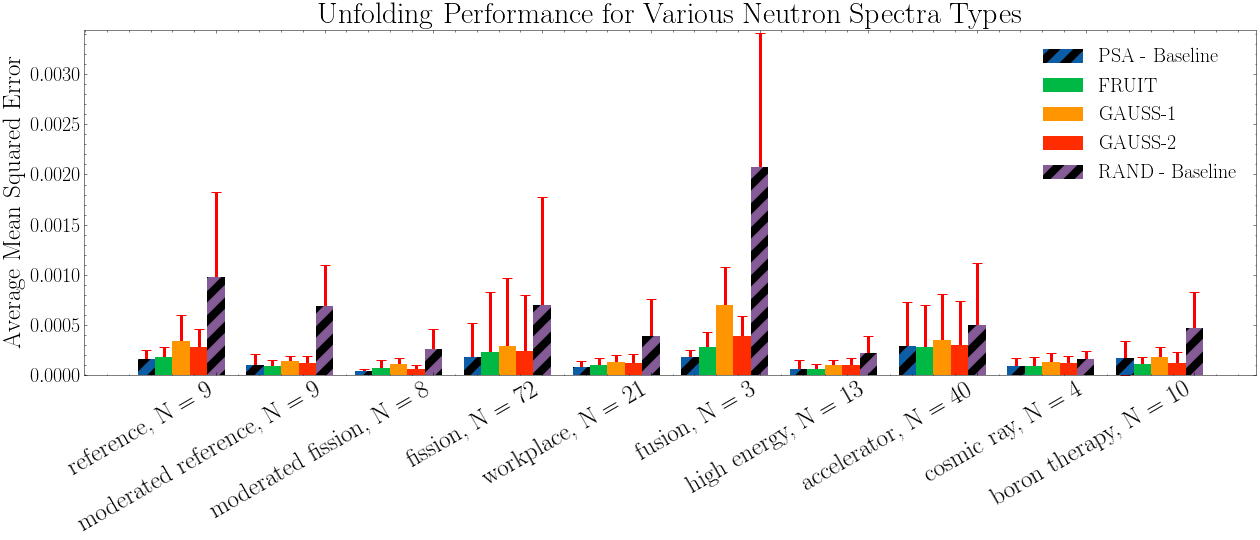

In [31]:
plt.rcParams['hatch.linewidth'] = 8

fig, ax = plt.subplots(1,1, figsize = (18, 8))

n = len(labels)
r = np.arange(n)
width = 0.16

plt.title("Unfolding Performance for Various Neutron Spectra Types", fontsize = 30, fontweight = "bold")

ax.bar(r - 2 * width, ltmPSA.values(), yerr = ltmPSA_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "PSA - Baseline", hatch = "/")
ax.bar(r - width, ltmFRUIT.values(), yerr = ltmFRUIT_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "FRUIT")
ax.bar(r, ltmGAUSS.values(), yerr = ltmGAUSS_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "GAUSS-1")
ax.bar(r + width, ltmGAUSS_SKEW.values(), yerr = ltmGAUSS_SKEW_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "GAUSS-2")
ax.bar(r + 2 * width, ltmRAND.values(), yerr = ltmRAND_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "RAND - Baseline", hatch = "/")

plt.ylabel("Average Mean Squared Error", fontsize = 25, fontweight = "bold")

plt.xticks(r + 2 * width, x_labels, rotation = 30, ha="right", fontsize = 25, fontweight = "bold")
ax.legend()

plt.ylim(0, 0.003435)

plt.tight_layout()

plt.savefig("unfolding_by_spectra_type", dpi = 300)



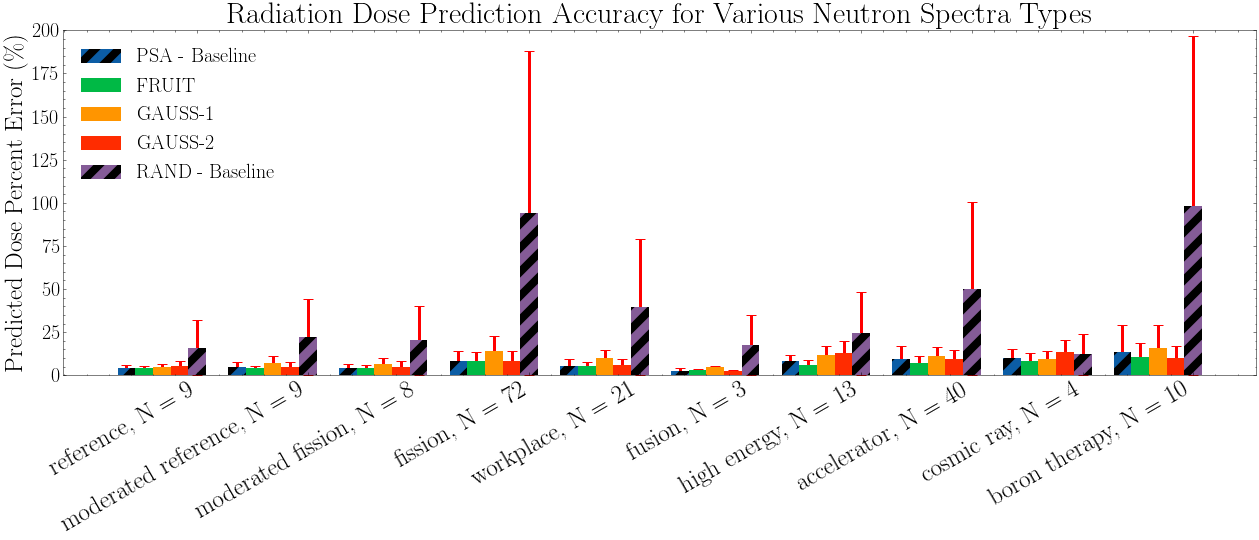

In [32]:
fig, ax = plt.subplots(1,1, figsize = (18, 8))

n = len(labels)
r = np.arange(n)
width = 0.16

plt.title("Radiation Dose Prediction Accuracy for Various Neutron Spectra Types", fontsize = 30, fontweight = "bold")

ax.bar(r - 2 * width, doseErrorPSA.values(), yerr = doseErrorPSA_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "PSA - Baseline", hatch = "/")
ax.bar(r - width, doseErrorFRUIT.values(), yerr = doseErrorFRUIT_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "FRUIT")
ax.bar(r, doseErrorGAUSS.values(), yerr = doseErrorGAUSS_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "GAUSS-1")
ax.bar(r + width, doseErrorGAUSS_SKEW.values(), yerr = doseErrorGAUSS_SKEW_DEV.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "GAUSS-2")
ax.bar(r + 2 * width, doseErrorRAND.values(), yerr = doseErrorRAND.values(), error_kw = dict(ecolor = "red", capsize = 5, zorder = 0), width = width, label = "RAND - Baseline", hatch = "/")

plt.xticks(r + 2 * width, x_labels, rotation = 30, ha="right", fontsize = 25, fontweight = "bold")
ax.legend()

plt.ylabel("Predicted Dose Percent Error (\%)", fontsize = 25, fontweight = "bold")

plt.tight_layout()
plt.ylim(0, 200)

plt.savefig("dose_by_spectra_type", dpi = 300)


In [32]:
np.where([l == "accelerator" for l in spectra_labels])

(array([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197]),)

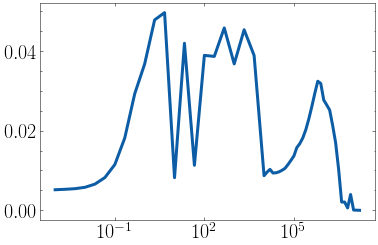

In [37]:
plt.plot(constants.Ebins, data_generation.y_data_IAEA[155])
plt.xscale("log")